# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

In [1]:
!pip install numpy scikit-image scipy matplotlib

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [1]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
GT_DIR = '../data/gt/'
RAW_DIR = '../data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

In [3]:
gt_image = skimage.io.imread(GT_DIR + 'IMG0001.bmp')
raw_image = skimage.io.imread(RAW_DIR + 'IMG0001.bmp')

print("Тип считанного изображения:", type(gt_image), type(raw_image))
print('Типы элементов матриц:', gt_image.dtype, raw_image.dtype)
print("Размеры:", np.array(gt_image).shape, np.array(raw_image).shape)

Тип считанного изображения: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Типы элементов матриц: uint8 uint8
Размеры: (512, 768, 3) (512, 768)


Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

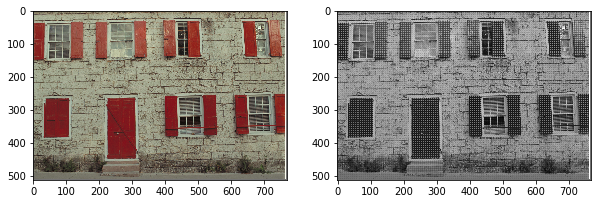

In [4]:
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [5]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    # green
    small_mask = np.array([[1, 0], [0, 1]])
    green_mask = np.tile(small_mask, ((h + 1) // 2 , (w + 1) // 2))[:h,:w]
    # red
    small_mask = np.array([[0, 1], [0, 0]])
    red_mask = np.tile(small_mask, ((h + 1) // 2 , (w + 1) // 2))[:h,:w]
    # blue
    small_mask = np.array([[0, 0], [1, 0]])
    blue_mask = np.tile(small_mask, ((h + 1) // 2 , (w + 1) // 2))[:h,:w]
    
    return red_mask, green_mask, blue_mask

Проверьте правильность работы  функции с помощью простейшего теста.

In [6]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [7]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
    red_mask, green_mask, blue_mask = get_bayer_pattern_masks(raw_image.shape[0], raw_image.shape[1])
    red_channel = red_mask * raw_image
    green_channel = green_mask * raw_image
    blue_channel = blue_mask * raw_image
    
    color_image = np.zeros((raw_image.shape[0], raw_image.shape[1], 3), dtype='uint8')
    color_image[:,:,0] = red_channel
    color_image[:,:,1] = green_channel
    color_image[:,:,2] = blue_channel
    return color_image

In [8]:
colored_raw_image = get_colored_raw_image(raw_image)
os.makedirs('results/', exist_ok=True)

skimage.io.imsave('results/colored_raw_image.bmp', colored_raw_image)

**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [9]:
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    colored_raw_image = np.array(get_colored_raw_image(raw_image), dtype=np.float64)
    colored_new_image = colored_raw_image.copy()
    
    for i in range(1, colored_raw_image.shape[0] - 1):
        for j in range(1, colored_raw_image.shape[1] - 1):
            r, g, b = colored_raw_image[i][j]
            neighbours = colored_raw_image[i - 1: i + 2, j - 1: j + 2]
            if r == 0:
                neighbour_sum_r = neighbours[:,:,0].sum()
                neighbour_count_r = (neighbours[:,:,0] != 0).sum()
                colored_new_image[i, j, 0] = neighbour_sum_r / neighbour_count_r
            if g == 0:
                neighbour_sum_g = neighbours[:,:,1].sum()
                neighbour_count_g = (neighbours[:,:,1] != 0).sum()
                colored_new_image[i, j, 1] = neighbour_sum_g / neighbour_count_g
            if b == 0:
                neighbour_sum_b = neighbours[:,:,2].sum()
                neighbour_count_b = (neighbours[:,:,2] != 0).sum()
                colored_new_image[i, j, 2] = neighbour_sum_b / neighbour_count_b
    return np.rint(colored_new_image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [10]:
# small test for self-examination
raw_image = skimage.io.imread('../data/raw/IMG0001.bmp')
image_true = skimage.io.imread('../data/debug/IMG0001_bilinear.bmp')
new_image = bilinear_interpolation(raw_image)
diff = np.abs(new_image - image_true)[1:-1, 1:-1].sum()
assert diff == 0

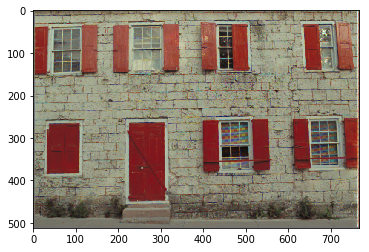

In [125]:
plt.imshow(new_image)
plt.show()

Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

In [11]:
OUTPUT_DIR = 'results/bilinear'
os.makedirs(OUTPUT_DIR, exist_ok=True)
names = next(os.walk('../data/raw'))[2]
for name in names:
    raw_image = skimage.io.imread('../data/raw/' + name)
    new_image = bilinear_interpolation(raw_image)
    skimage.io.imsave(OUTPUT_DIR + '/' + name, new_image)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


**Выводы:**

Видим, что получиось довольно реалистично. Кроме того, если сравнить полученное с оригинальными картинками, можно понять, что билинейная интерполяция дает действительно хорошие результаты. Однако можно заметить, что жалюзи на окнах принимают неверный цвет.

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [12]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """

    pred_image = pred_image.astype(np.float64)[2:-2, 2:-2]
    gt_image = gt_image.astype(np.float64)[2:-2, 2:-2]
    return ((pred_image - gt_image) ** 2).mean()


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image.astype(np.float64)[2:-2, 2:-2]
    gt_image = gt_image.astype(np.float64)[2:-2, 2:-2]
    return 10 * np.log10((np.max(gt_image) ** 2) / mse_score(pred_image, gt_image))

Посмотрим на метрики для первой картинки для написанного алгоритма

In [13]:
raw_image = skimage.io.imread('../data/raw/IMG0001.bmp')
true_image = skimage.io.imread('../data/gt/IMG0001.bmp')
pred_image = bilinear_interpolation(raw_image)
print('mse : ', mse_score(pred_image, true_image))
print('psnr : ', psnr_score(pred_image, true_image))

mse :  158.87617234200437
psnr :  26.143987015549925


**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [14]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [15]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    raw_image = raw_image.astype(np.float64)
    colored_raw_image = np.array(get_colored_raw_image(raw_image), dtype=np.float64)
    colored_new_image = colored_raw_image.copy()
    red_mask, green_mask, blue_mask = get_bayer_pattern_masks(raw_image.shape[0], raw_image.shape[1])
    
    for i in range(2, colored_raw_image.shape[0] - 2):
        for j in range(2, colored_raw_image.shape[1] - 2):
#             r, g, b = colored_raw_image[i, j]
            neighbours = colored_raw_image[i - 2: i + 3, j - 2: j + 3]
            neighbours_sum = neighbours.sum(axis=-1)
            if red_mask[i, j] != 0:
                interpolated_green = (weigths_3 * neighbours_sum).sum()
                interpolated_blue = (weigths_2 * neighbours_sum).sum()
                colored_new_image[i, j, 1] = interpolated_green
                colored_new_image[i, j, 2] = interpolated_blue
            elif green_mask[i, j] != 0:
                if colored_raw_image[i - 1, j, 0] != 0: 
                    interpolated_red = (weigths_1 * neighbours_sum).sum()
                    interpolated_blue = (weigths_0 * neighbours_sum).sum()
                    colored_new_image[i, j, 0] = interpolated_red
                    colored_new_image[i, j, 2] = interpolated_blue
                else:
                    interpolated_red = (weigths_0 * neighbours_sum).sum()
                    interpolated_blue = (weigths_1 * neighbours_sum).sum()
                    colored_new_image[i, j, 0] = interpolated_red
                    colored_new_image[i, j, 2] = interpolated_blue
            elif blue_mask[i, j] != 0:
                interpolated_red = (weigths_2 * neighbours_sum).sum()
                interpolated_green = (weigths_3 * neighbours_sum).sum()
                colored_new_image[i, j, 0] = interpolated_red
                colored_new_image[i, j, 1] = interpolated_green

    return np.rint(np.clip(colored_new_image, 0, 255)).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [16]:
# small test for self-examination
raw_image = skimage.io.imread('../data/raw/IMG0001.bmp')
image_true = skimage.io.imread('../data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
assert diff == 0

Посмотрим, что получилось

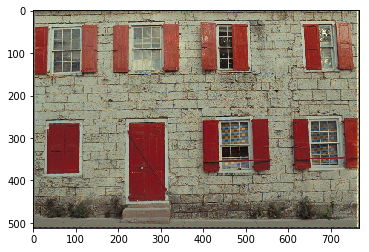

In [17]:
plt.imshow(improved_linear_interpolation(raw_image))
plt.show()

Проделаем то же самое для всех картинок

In [19]:
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2)

names = next(os.walk('../data/raw'))[2]
for name in names:
    raw_image = skimage.io.imread('../data/raw/' + name)
    new_image = improved_linear_interpolation(raw_image)
    skimage.io.imsave(OUTPUT_DIR2 + '/' + name, new_image)


**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

Посмотрим на метрики для первой картинки

In [22]:
raw_image = skimage.io.imread('../data/raw/IMG0001.bmp')
image_first = bilinear_interpolation(raw_image)
image_second = improved_linear_interpolation(raw_image)
image_true = skimage.io.imread('../data/gt/IMG0001.bmp')

print('mse for first alogorithm: ', mse_score(image_first, image_true))
print('mse for second algorithm: ', mse_score(image_second, image_true))
print('\npsnr for first alogorithm: ', psnr_score(image_first, image_true))
print('psnr for second alogorithm: ', psnr_score(image_second, image_true))

mse for first alogorithm:  158.87617234200437
mse for second algorithm:  68.3623996853142

psnr for first alogorithm:  26.143987015549925
psnr for second alogorithm:  29.85172665243113


Усредним метрики по всем картинкам.

In [23]:
mses1 = []
mses2 = []
psnr1 = []
psnr2 = []
for name in names:
    image_first = skimage.io.imread(OUTPUT_DIR + '/' + name)
    image_second = skimage.io.imread(OUTPUT_DIR2 + '/' + name)
    image_true = skimage.io.imread('../data/gt/' + name)
    mses1.append(mse_score(image_first, image_true))
    mses2.append(mse_score(image_second, image_true))
    psnr1.append(psnr_score(image_first, image_true))
    psnr2.append(psnr_score(image_second, image_true))
    
print('mean mse for first alogorithm : ', np.array(mses1).mean())
print('mean mse for second alogorithm : ', np.array(mses2).mean())
print('\nmean psnr mse for first alogorithm : ', np.array(psnr1).mean())
print('mean psnr mse for second alogorithm : ', np.array(psnr2).mean())

mean mse for first alogorithm :  73.2378932069437
mean mse for second alogorithm :  36.57598812398941

mean psnr mse for first alogorithm :  30.491127618166008
mean psnr mse for second alogorithm :  33.329882466349055


Посмотрим сначала на некоторые открытые окна

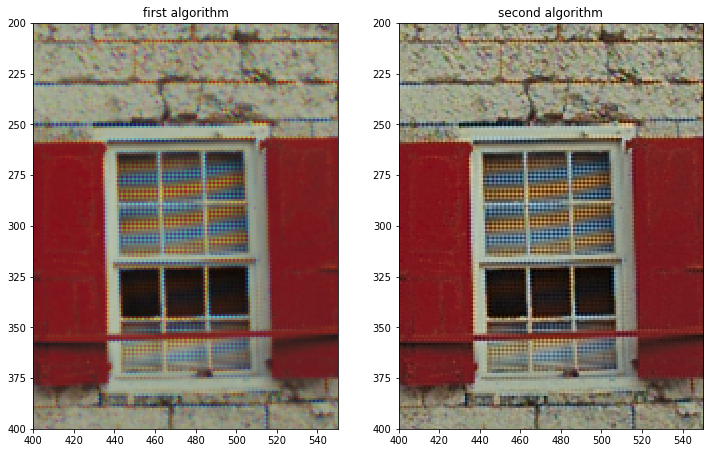

In [24]:
raw_image = skimage.io.imread('../data/raw/IMG0001.bmp')
image_first = bilinear_interpolation(raw_image)
image_second = improved_linear_interpolation(raw_image)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(400, 200)
plt.xlim(400, 550)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(400, 200)
plt.xlim(400, 550)
plt.title('second algorithm')
plt.show()

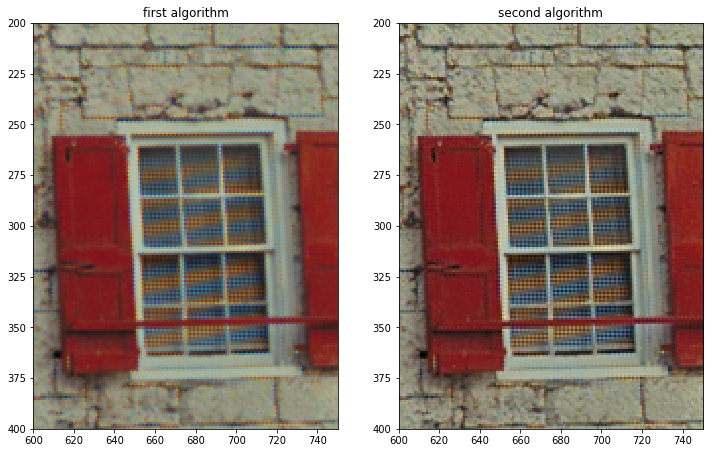

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(400, 200)
plt.xlim(600, 750)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(400, 200)
plt.xlim(600, 750)
plt.title('second algorithm')
plt.show()

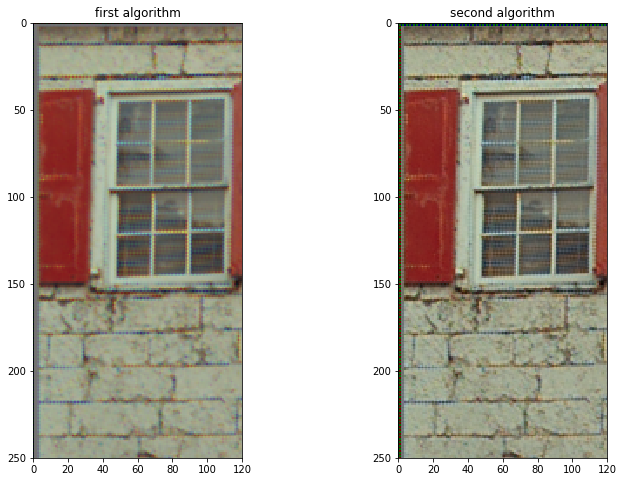

In [26]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(250, 0)
plt.xlim(0, 120)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(250, 0)
plt.xlim(0, 120)
plt.title('second algorithm')
plt.show()

Посмотрим также на дверь

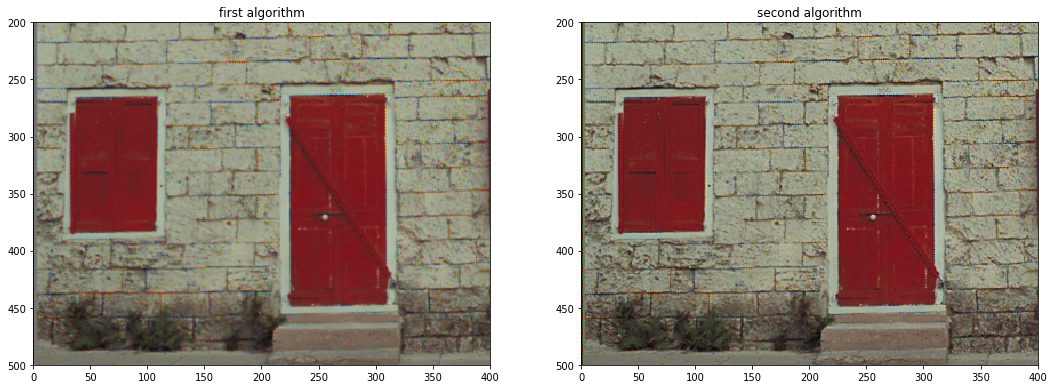

In [27]:
plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(500, 200)
plt.xlim(0, 400)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(500, 200)
plt.xlim(0, 400)
plt.title('second algorithm')
plt.show()

Сравним теперь результат для второй картинки

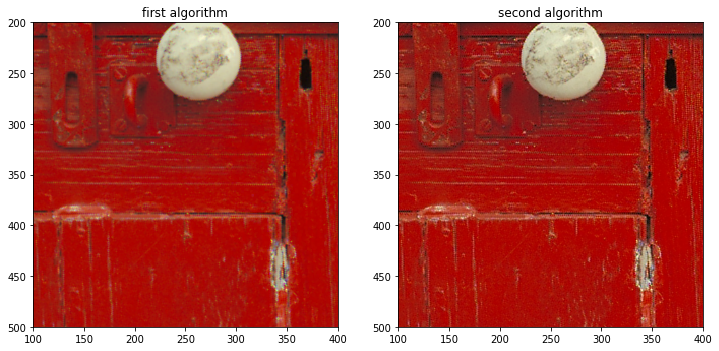

In [36]:
raw_image = skimage.io.imread('../data/raw/IMG0002.bmp')
image_first = bilinear_interpolation(raw_image)
image_second = improved_linear_interpolation(raw_image)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(500, 200)
plt.xlim(100, 400)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(500, 200)
plt.xlim(100, 400)
plt.title('second algorithm')
plt.show()

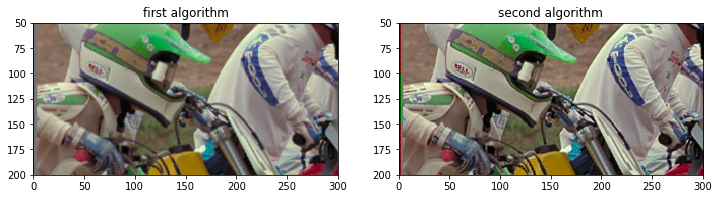

In [35]:
raw_image = skimage.io.imread('../data/raw/IMG0005.bmp')
image_first = bilinear_interpolation(raw_image)
image_second = improved_linear_interpolation(raw_image)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_first)
plt.ylim(200, 50)
plt.xlim(0, 300)
plt.title('first algorithm')

plt.subplot(1, 2, 2)
plt.imshow(image_second)
plt.ylim(200, 50)
plt.xlim(0, 300)
plt.title('second algorithm')
plt.show()

**Выводы: **

Как видим, по нескольким картинкам, второй алгоритм дает более четкое изображение, чем первый алгоритм. Кроме того, мы увидели, что mse в среднем получился в 2 раза меньше при использовании второго алгоритма и также метрика psnr также получилась лучше (больше). 